In [1]:
# Importamos las librerias
import fastf1 as f1
import fastf1.plotting
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Cargamos una carpeta cache para guardar los datos descargados
f1.Cache.enable_cache('cache')

In [3]:
# Cargamos los datos del AUSTRALIAN GRAND PRIX 2025
sesion = f1.get_session(2025, 1, 'R')

# Sesion, nombre y fecha de la carrera
print(sesion.name)
print(sesion.event.OfficialEventName)
print(sesion.date)

Race
FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX 2025
2025-03-16 04:00:00


In [4]:
# Cargamos la informacion de la carrera
sesion.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']


In [5]:
sesion.results[['GridPosition', 'Position', 'BroadcastName', 'Abbreviation', 'TeamName', 'Status', 'Points']]

,GridPosition,Position,BroadcastName,Abbreviation,TeamName,Status,Points
4,1.0,1.0,L NORRIS,NOR,McLaren,Finished,25.0
1,3.0,2.0,M VERSTAPPEN,VER,Red Bull Racing,Finished,18.0
63,4.0,3.0,G RUSSELL,RUS,Mercedes,Finished,15.0
12,16.0,4.0,A ANTONELLI,ANT,Mercedes,Finished,12.0
23,6.0,5.0,A ALBON,ALB,Williams,Finished,10.0
18,13.0,6.0,L STROLL,STR,Aston Martin,Finished,8.0
27,17.0,7.0,N HULKENBERG,HUL,Kick Sauber,Finished,6.0
16,7.0,8.0,C LECLERC,LEC,Ferrari,Finished,4.0
81,2.0,9.0,O PIASTRI,PIA,McLaren,Finished,2.0
44,8.0,10.0,L HAMILTON,HAM,Ferrari,Finished,1.0


## Ritmo de carrera de los equipos

In [6]:
# Seleccionamos las vueltas mas rapidas de cada piloto
# En esta ocasion, seleccionamos las vueltas mas rapidas de cada piloto que no hayan abandonado la carrera
pilotos_no_terminaron = sesion.results[sesion.results['Status'] != 'Finished']['Abbreviation']
vueltas = sesion.laps.query('Driver not in @pilotos_no_terminaron')

In [7]:
# Cambiamos el formato de la columna LapTime a segundos
transform_vueltas = vueltas.copy()
transform_vueltas.loc[:, "LapTime (s)"] = vueltas["LapTime"].dt.total_seconds()

# Nos quedamos con las vueltas dentro del rango de 80 a 100 segundos
transform_vueltas = transform_vueltas.query("80 < `LapTime (s)` < 100")

# Ordenamos los equipos segun la mediana de tiempo, desde el mas rapido al mas lento
equipos = (
    transform_vueltas[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)

# Asociamos los equipos con sus respectivos colores
paleta_colores = {team: f1.plotting.get_team_color(team, session=sesion) for team in equipos}

req            INFO 	Using cached data for driver_info


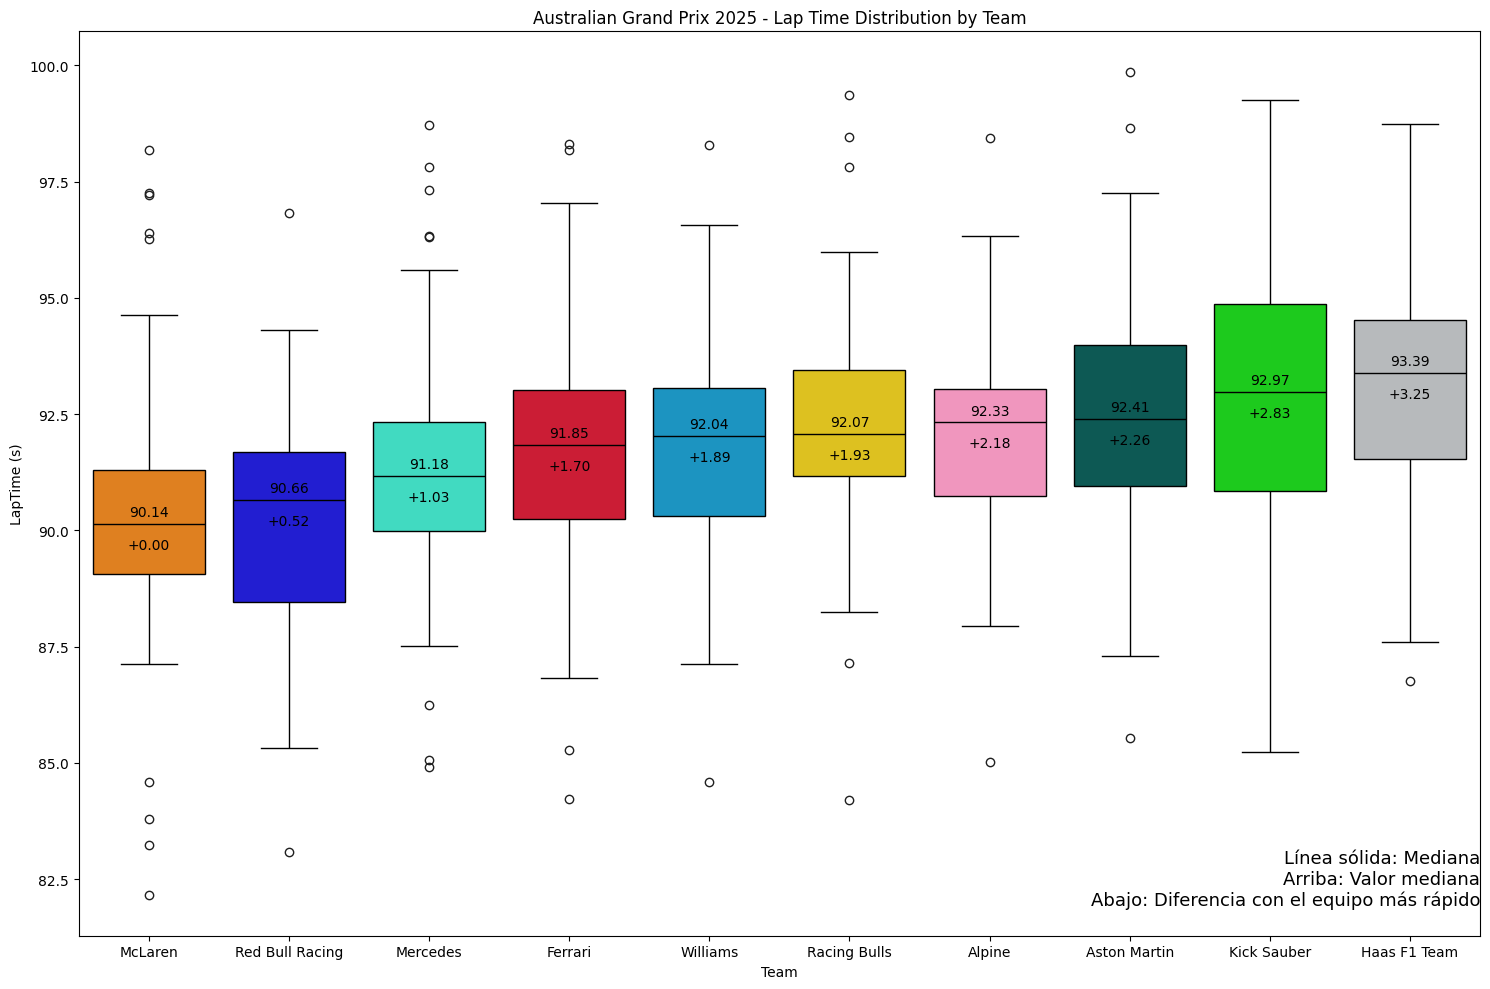

In [8]:
# Boxplots comparativos de ritmo de carrera entre los distintos equipos
fig, ax = plt.subplots(figsize=(15, 10))  # tamaño gráfico
ax.set_facecolor('white')         # fondo del área de los ejes

sns.boxplot(
    data=transform_vueltas[["Team", "LapTime (s)"]],  # datos a representar
    x="Team",  # datos eje x
    y="LapTime (s)",  # datos eje y
    hue="Team",  # datos para diferenciar los colores
    order=equipos,  # orden de los equipos
    palette=paleta_colores,  # paleta de colores de cada equipo
    whiskerprops=dict(color="black"),  # color de las líneas que marcan los bigotes
    boxprops=dict(edgecolor="black"),  # color de los bordes de las cajas
    medianprops=dict(color="black"),  # color de la mediana
    capprops=dict(color="black"),  # color de las líneas que marcan los bigotes
    showfliers=True,  # mostrar los outliers
    flierprops=dict(marker='o', color='black', alpha=1, markersize=6)  # propiedades de los outliers
)
# Añadimos la mediana y la diferencia con el primer equipo
for i, equipo in enumerate(equipos):
    mediana = transform_vueltas[transform_vueltas["Team"] == equipo]["LapTime (s)"].median()
    ax.text(
        i, mediana + 0.1,  # Ajusta la posición vertical
        f'{mediana:.2f}',  # Formato de la mediana
        color='black',  # Color del texto
        ha='center',  # Alineación horizontal
        va='bottom'
    )
    
    # Diferencia con la mediana de todos los equipos con los del primer equipo
    diferencia = mediana - transform_vueltas[transform_vueltas["Team"] == equipos[0]]["LapTime (s)"].median()
    ax.text(
        i, mediana - 0.3,  # Ajusta la posición vertical según sea necesario
        f'+{diferencia:.2f}',  # Formato de la diferencia
        color='black',
        ha='center',
        va='top'
    )

# Títulos y etiquetas del gráfico
plt.title(f"{sesion.event['EventName']} {sesion.event.year} - Lap Time Distribution by Team")
plt.grid(visible=False)
ax.text(
    x=9.5,  # Coordenada X 
    y=82.5,  # Coordenada Y 
    s="Línea sólida: Mediana\nArriba: Valor mediana\nAbajo: Diferencia con el equipo más rápido",  # Texto
    color="black",  # Color del texto
    fontsize=13,  # Tamaño de la fuente
    ha="right",  # Alineación horizontal ('center', 'left', 'right')
    va="center",  # Alineación vertical ('center', 'top', 'bottom')
)

# Guardamos gráfico
path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/ritmo_carrera_equipos.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

## Ritmo de carrera de cada piloto

In [9]:
# Seleccionamos a los pilotos
pilotos = sesion.drivers
pilotos_laps = sesion.laps.pick_drivers(pilotos)
pilotos_laps = pilotos_laps.reset_index()

# Ordenamos segun las pocisiones finales
posicines_finales = [sesion.get_driver(i)["Abbreviation"] for i in pilotos]

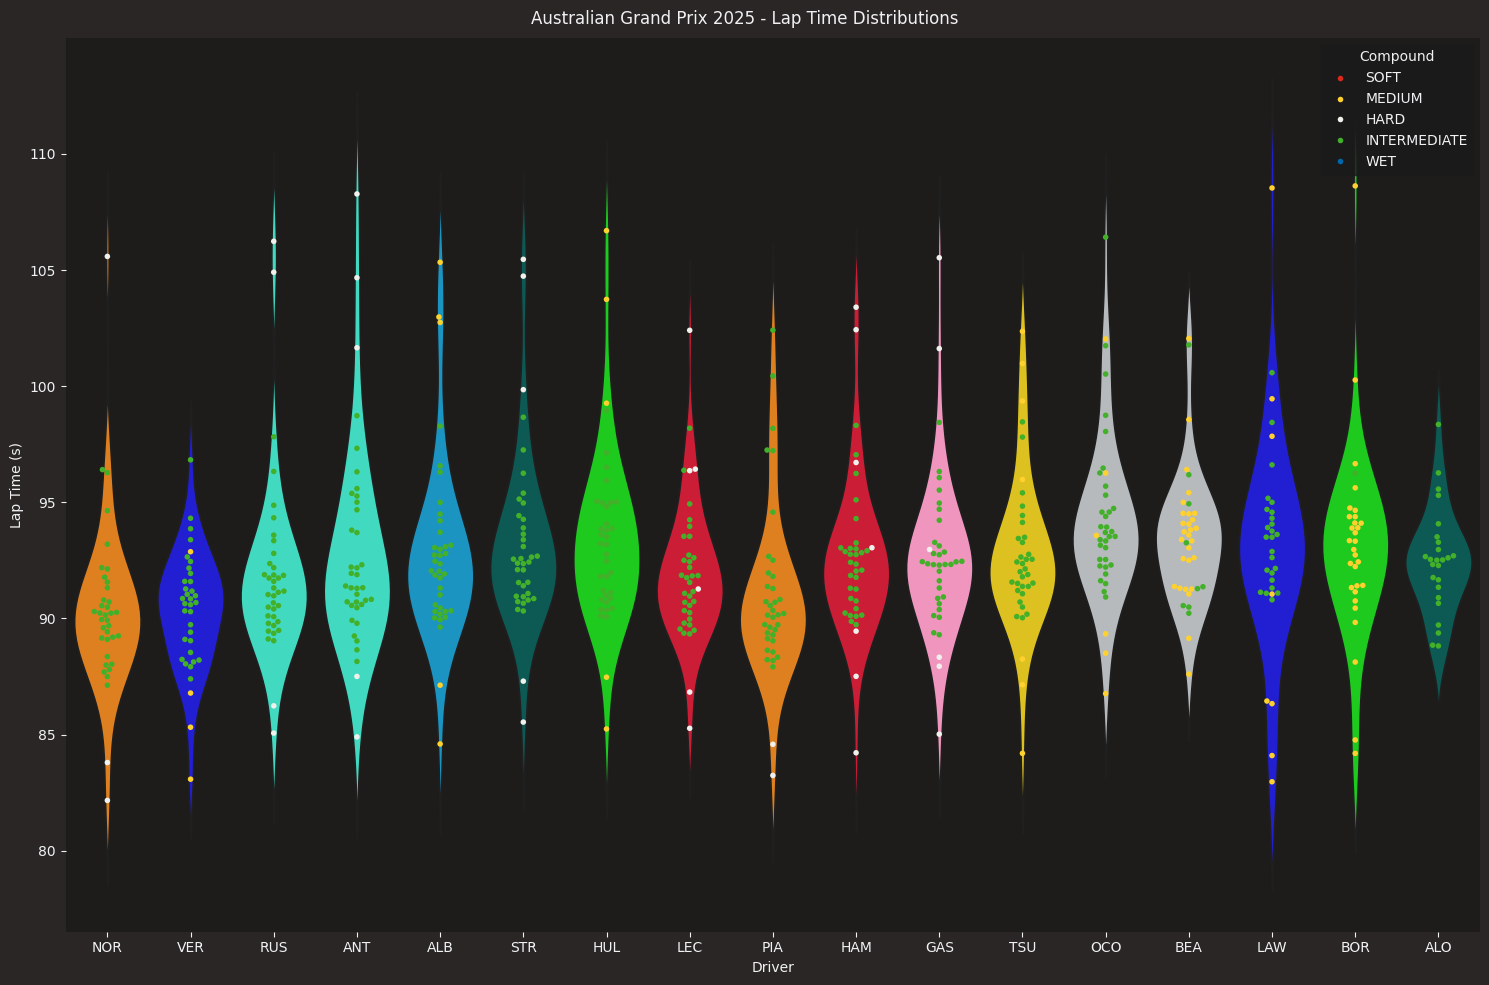

In [10]:
# Configuramos el esquema de color
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False, color_scheme='fastf1')

# Convertimos los tiempos de vuelta a segundos
pilotos_laps["LapTime(s)"] = pilotos_laps["LapTime"].dt.total_seconds()

# Eliminamos las vueltas que sean mayores a 110 segundos
pilotos_laps = pilotos_laps.query("`LapTime(s)` < 110")

# Eliminamos los tiempos de vuelta de los pilotos que dieron pocas vueltas
pilotos_a_eliminar = ['SAI', 'DOO', 'HAD']
pilotos_laps = pilotos_laps[~pilotos_laps['Driver'].isin(pilotos_a_eliminar)]
posicines_finales = [driver for driver in posicines_finales if driver not in pilotos_a_eliminar]

# Grafico de violines y swarmplot
fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(data=pilotos_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=posicines_finales,
               palette=fastf1.plotting.get_driver_color_mapping(session=sesion)
               )

sns.swarmplot(data=pilotos_laps,
              x="Driver",
              y="LapTime(s)",
              order=posicines_finales,
              hue="Compound",
              palette=fastf1.plotting.get_compound_mapping(session=sesion),
              hue_order=["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"],
              linewidth=0,
              size=4,
              )

# Configuracion del grafico
ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
plt.suptitle(f"{sesion.event['EventName']} {sesion.event.year} - Lap Time Distributions")
sns.despine(left=True, bottom=True)

# Mover la leyenda a la parte superior derecha
ax.legend(bbox_to_anchor=(1, 1), loc='upper right')
ax.legend_.set_title("Compound")

# Guardar el gráfico
path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/ritmo_carrera_pilotos.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

## Ritmo de carrera ordenado según la mediana de tiempo de vuelta

In [11]:
# Calculamos la media de tiempo de vuelta de cada piloto y los ordenamos
# En esta ocasion, eliminamos a los pilotos que abandonaron la carrera
pilotos_a_eliminar = ['LAW', 'BOR', 'ALO', 'SAI', 'DOO', 'HAD']
pilotos_laps = pilotos_laps[~pilotos_laps['Driver'].isin(pilotos_a_eliminar)]
posicines_finales = [driver for driver in posicines_finales if driver not in pilotos_a_eliminar]

# Filtramos los tiempos que esten dentro del rango de 80 a 100 segundos
pilotos_laps = pilotos_laps.query("`LapTime(s)` < 100")
media_tiempos = pilotos_laps.groupby('Driver')['LapTime(s)'].mean().sort_values()
medianas_tiempos = pilotos_laps.groupby('Driver')['LapTime(s)'].median().sort_values()

C:\Users\Laura\AppData\Local\Temp\ipykernel_11128\3942135093.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


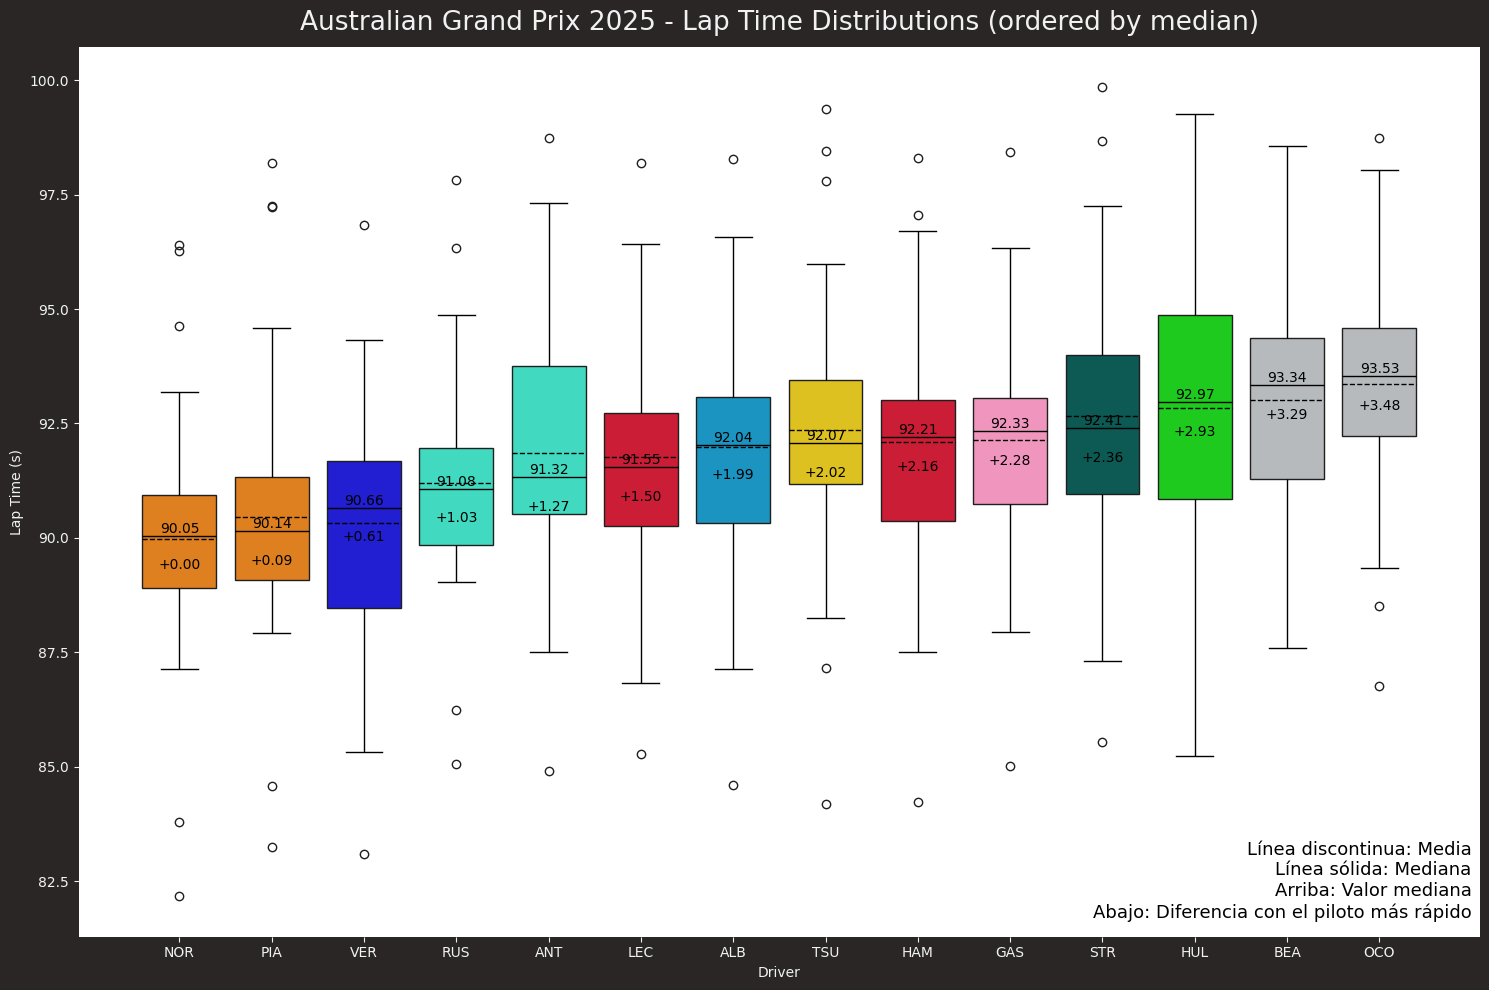

In [12]:
# Diferencia de la mediana de tiempos con respecto al primer piloto
diferencias_medianas = {piloto: medianas_tiempos[piloto] - medianas_tiempos.iloc[0] for piloto in medianas_tiempos.index}

# Ordenar los pilotos de menor a mayor, segun la diferencia
posicines_finales = sorted(diferencias_medianas, key=diferencias_medianas.get)

# Boxplots
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('white')  # Fondo

sns.boxplot(
    data=pilotos_laps,
    x="Driver",
    y="LapTime(s)",
    order=posicines_finales,
    palette=fastf1.plotting.get_driver_color_mapping(session=sesion),
    whiskerprops=dict(color="black"),
    medianprops=dict(color="black"),
    capprops=dict(color="black"),
)

# Líneas discontinuas y media de tiempo
for i, piloto in enumerate(posicines_finales):
    media = media_tiempos[piloto]
    mediana = medianas_tiempos[piloto]
    ax.plot(
        [i - 0.4, i + 0.4],  
        [media, media],       
        color='black',          
        linestyle='--',       
        linewidth=1,
    )
    # Valor de la mediana
    ax.text(
        i, mediana,  # posición vertical 
        f'{mediana:.2f}',
        color='black',
        ha='center',
        va='bottom'
    )
    
    # Diferencia con la mediana del primer piloto
    diferencia = mediana - medianas_tiempos.iloc[0]
    ax.text(
        i, mediana - 0.5,  
        f'+{diferencia:.2f}',
        color='black',
        ha='center',
        va='top'
    )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
ax.text(
    x=14,  # Coordenada X 
    y=82.5,  # Coordenada Y 
    s="Línea discontinua: Media\nLínea sólida: Mediana\nArriba: Valor mediana\nAbajo: Diferencia con el piloto más rápido",  # Texto
    color="black",  # Color del texto
    fontsize=13,  # Tamaño de la fuente
    ha="right",  # Alineación horizontal ('center', 'left', 'right')
    va="center",  # Alineación vertical ('center', 'top', 'bottom')
)
plt.title(f"{sesion.event['EventName']} {sesion.event.year} - Lap Time Distributions (ordered by median)")
sns.despine(left=True, bottom=True)
plt.grid(visible=False)

# Guardar el gráfico
path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/ritmo_carrera_ordenados_media.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

## Cambios de posición de los pilotos en cada vuelta

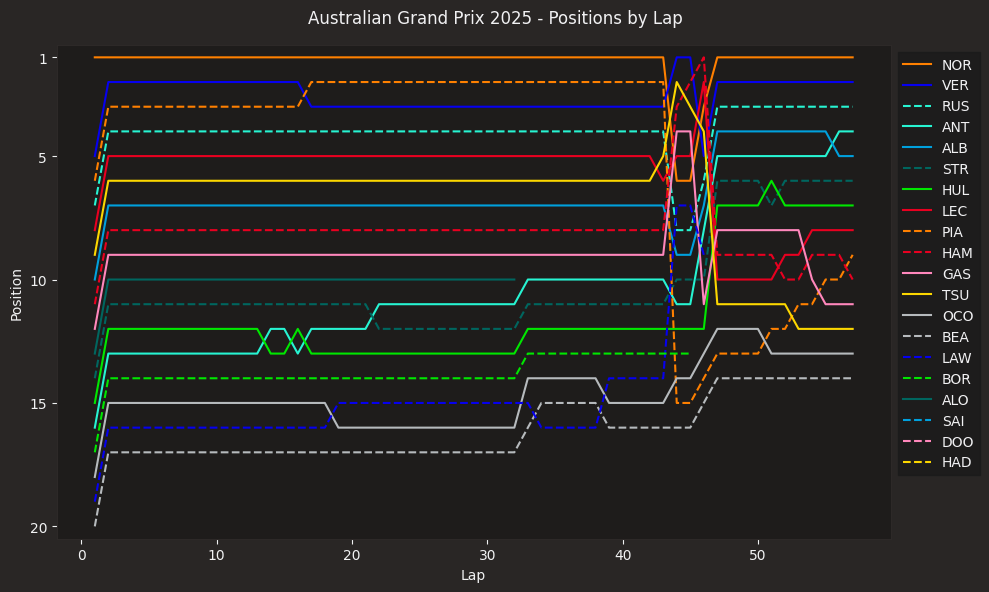

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Extraemos los datos de la posición de cada piloto en cada vuelta
for piloto in sesion.drivers:
    piloto_laps = sesion.laps.pick_drivers(piloto)
    if not piloto_laps.empty:
        abb = piloto_laps['Driver'].iloc[0]
        style = fastf1.plotting.get_driver_style(identifier=abb,
                                                 style=['color', 'linestyle'],
                                                 session=sesion)
        ax.plot(piloto_laps['LapNumber'], piloto_laps['Position'],
                label=abb, **style)

# Configuración del gráfico
plt.suptitle(f"{sesion.event['EventName']} {sesion.event.year} - Positions by Lap")
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

# Leyenda
ax.legend(bbox_to_anchor=(1, 1))

# Guardar el gráfico
path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/cambios_posiciones.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

In [14]:
diferencias_posiciones = [
 ['NOR', 0],
 ['VER', 1],
 ['RUS', 1],
 ['ANT', 12],
 ['ALB', 1],
 ['STR', 7],
 ['HUL', 10],
 ['LEC', -1],
 ['PIA', -7],
 ['HAM', -2],
 ['GAS', -2],
 ['TSU', -7],
 ['OCO', 6],
 ['BEA', 6]]


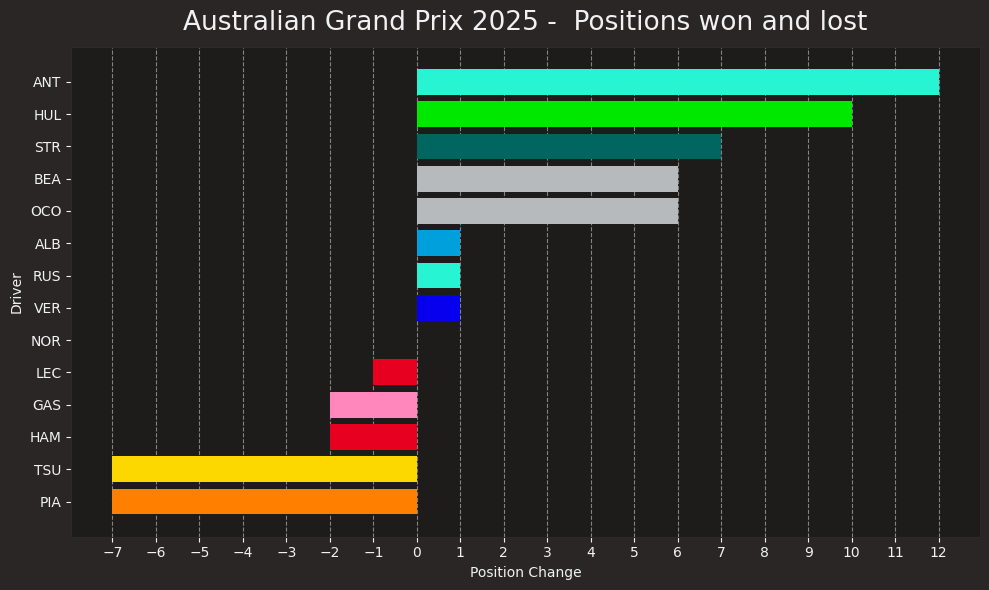

In [15]:
# Convertimos diferencias_posiciones a un diccionario para facilitar el uso
diferencias_posiciones_dict = dict(diferencias_posiciones)

# Ordenamos las diferencias de posiciones de manera ascendentes
diferencias_posiciones_ordenadas = dict(sorted(diferencias_posiciones_dict.items(), key=lambda x: x[1], reverse=False))

# Asociamos los colores de los pilotos según su equipo
colores_pilotos = [fastf1.plotting.get_team_color(sesion.get_driver(driver)["TeamName"], session=sesion) for driver in diferencias_posiciones_ordenadas.keys()]

# Creamos un gráfico de barras horizontales
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(diferencias_posiciones_ordenadas.keys()), list(diferencias_posiciones_ordenadas.values()), color=colores_pilotos)

# Configuración del gráfico
ax.set_xlabel('Position Change')
ax.set_ylabel('Driver')
ax.set_title(f"{sesion.event['EventName']} {sesion.event.year} -  Positions won and lost")
ax.set_xticks(range(min(diferencias_posiciones_ordenadas.values()), max(diferencias_posiciones_ordenadas.values()) + 1))
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Guardar el gráfico
path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/cambios_posiciones_barras.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

## Adelantamiento de Piastri a Hamilton en la ultima vuelta

In [16]:
# Seleccionamos la vuelta de Piastri
pia_vuelta = sesion.laps.pick_drivers('PIA').pick_laps(57)

# Seleccionamos la vuelta de Hamilton
ham_vuelta = sesion.laps.pick_drivers('HAM').pick_laps(57)

# Telemetria de la vuelta de cada uno
pia_tel = pia_vuelta.get_car_data().add_distance()
ham_tel = ham_vuelta.get_car_data().add_distance()

# Informacion del circuito
circuit_info = sesion.get_circuit_info()

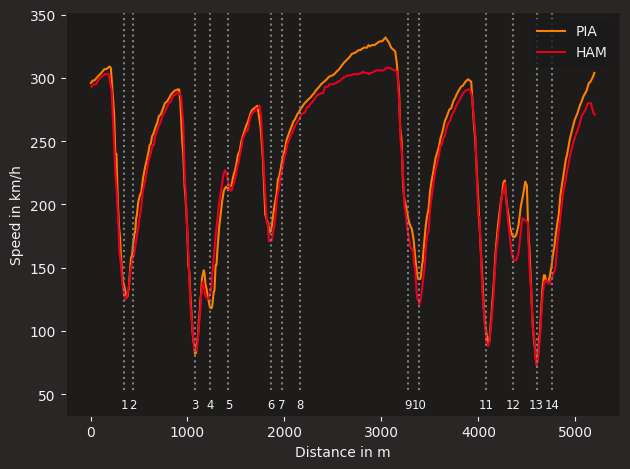

In [17]:
pia_color = fastf1.plotting.get_team_color(pia_vuelta['Team'].iloc[0], session=sesion)
ham_color = fastf1.plotting.get_team_color(ham_vuelta['Team'].iloc[0], session=sesion)

# Crear el gráfico
fig, ax = plt.subplots()

# Agregar la telemetría de Piastri
ax.plot(pia_tel['Distance'], pia_tel['Speed'], color=pia_color, label=pia_vuelta['Driver'])

# Agregar la telemetría de Hamilton
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=ham_color, label=ham_vuelta['Driver'])

# Agregar líneas verticales para cada curva
v_min = min(pia_tel['Speed'].min(), ham_tel['Speed'].min())
v_max = max(pia_tel['Speed'].max(), ham_tel['Speed'].max())
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')

# Enumerar las curvas
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-30, txt, va='center_baseline', ha='center', size='small')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend()

# Agrandar los límites del eje Y para mejorar la visualización
ax.set_ylim([v_min - 40, v_max + 20])

path = 'D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/Piastri_vs_Hamilton.png'
plt.savefig(path, dpi=300)
plt.tight_layout()
plt.show()

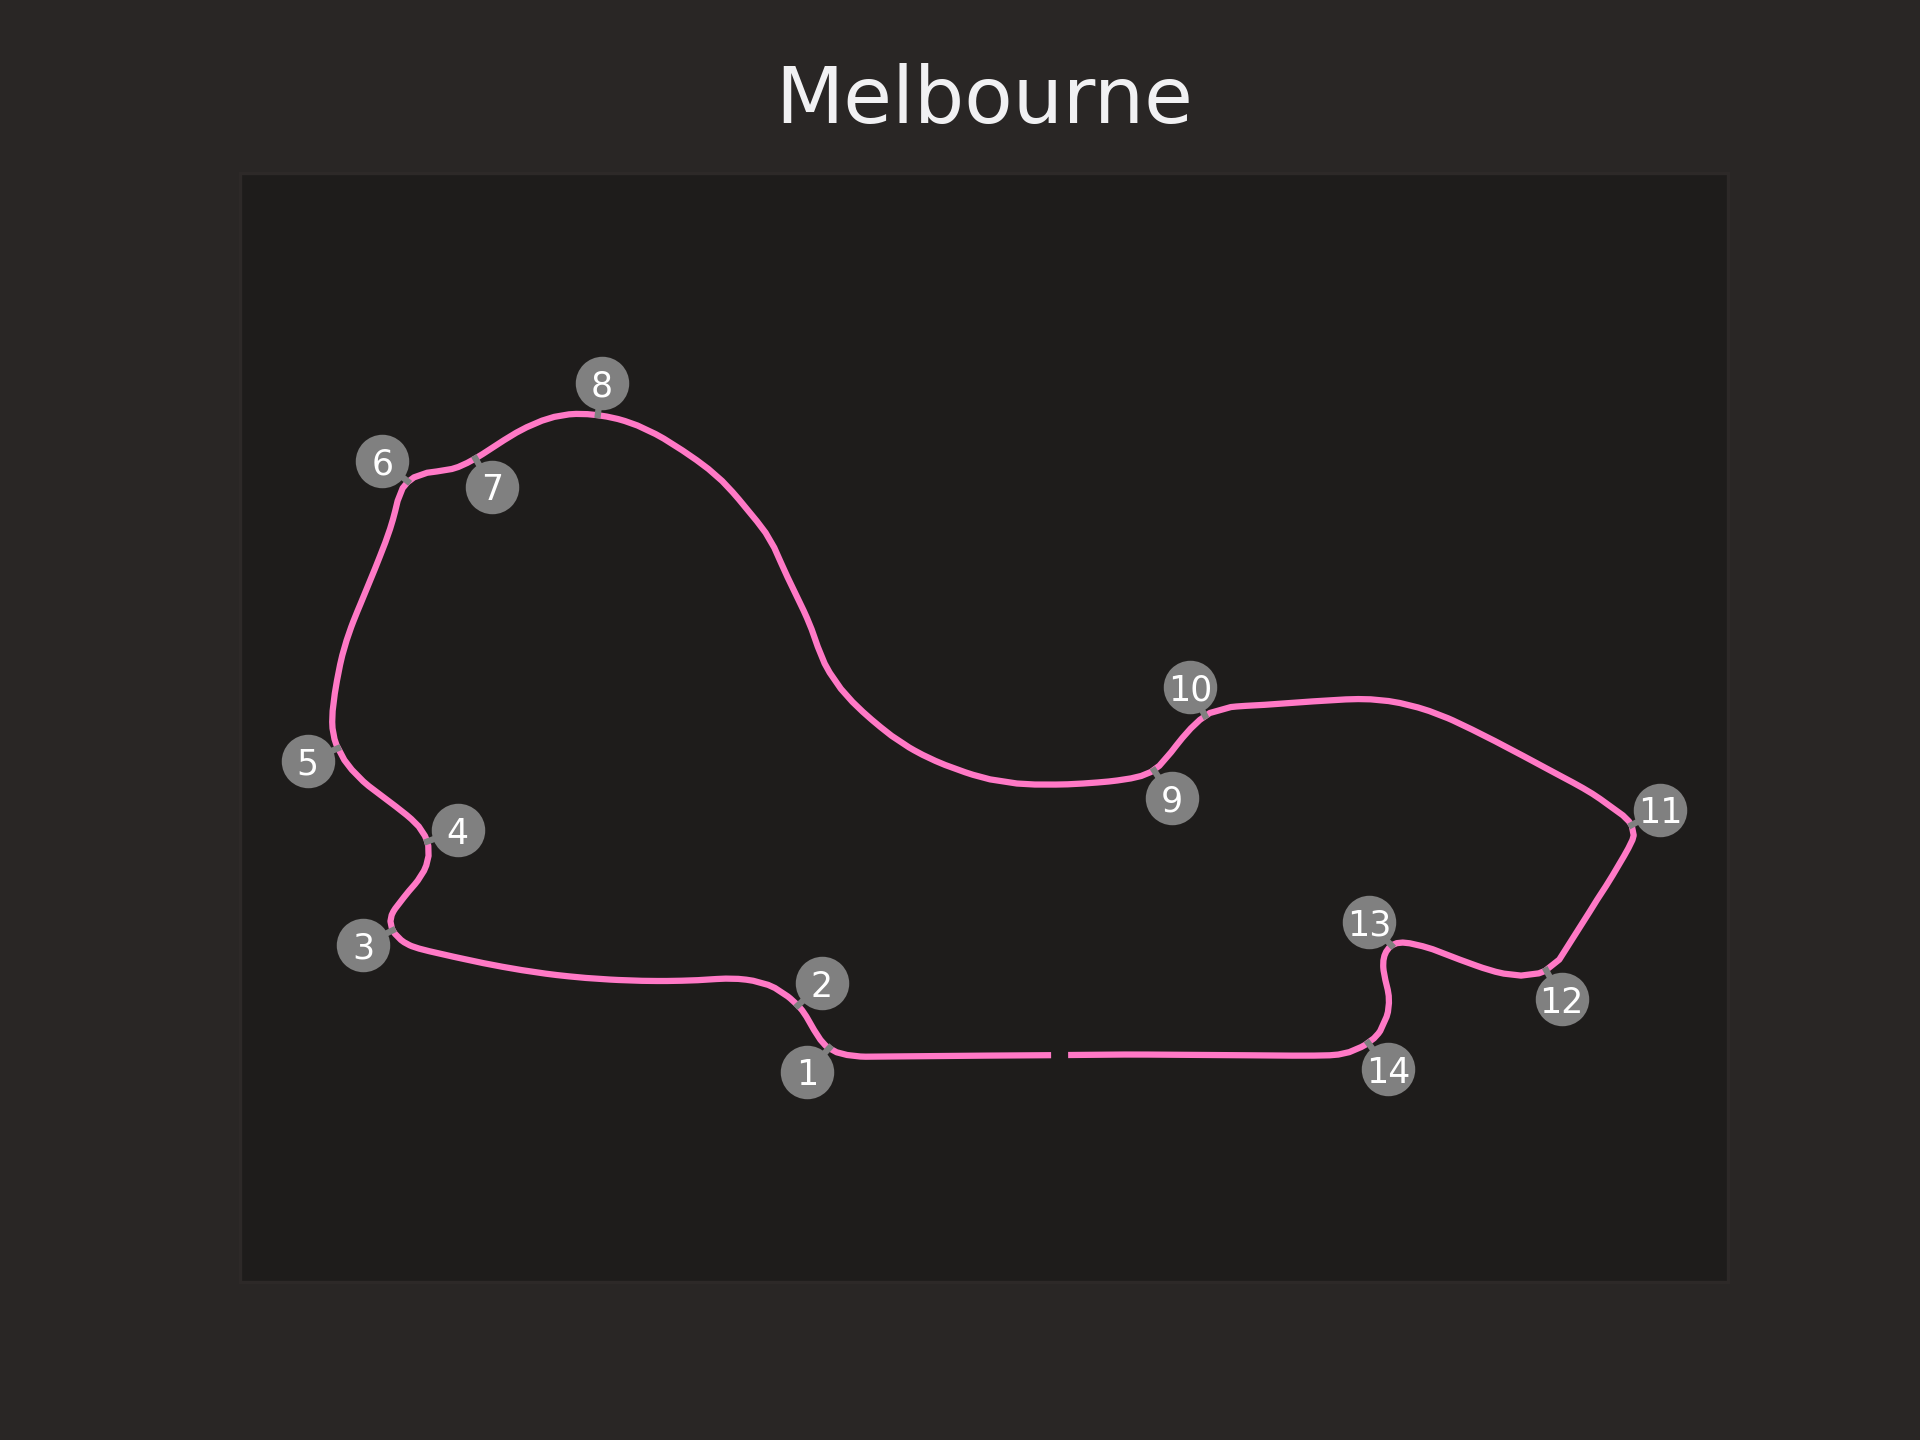

In [18]:
from IPython.display import Image
display(Image(filename="D:/Users/Laura/Documents/Proyecto Análisis F1/Formula-1/Temporada 2025/01_AUSTRALIA/graphics/info_circuit.png", width=700))